In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np 
import matplotlib.pyplot as plt
from collections import OrderedDict

from torch.utils.data import Dataset

In [2]:
cyl_data = np.load('data_numpy.npy')

xy_coords = np.load('xy_coords.npy').T

In [3]:
''' 
Note the shape of our cylinder data:
2000 timesteps, 
3 flow descriptors (x-velocity, y-velocity, vorticity), 
8744 grid points (interpolated elements onto FEM triangle centers)

xy_coords gives array where row 1 is x-coords & row 2 is y-coords
'''
print(cyl_data.shape)
print(xy_coords.shape)

(2000, 3, 8744)
(2, 8744)


# Vizualization

In [4]:
def plot_cyl(coords, field, ax, levels=18):
    numOfLevels=levels
    vort_levels = np.append(np.append(np.array([-40]),np.linspace(-2,2,numOfLevels)),40)

    ax.tricontourf(coords[0],coords[1], field, levels=vort_levels, vmin = -2,vmax=2, cmap='RdBu')
    circle = plt.Circle((0, 0), 0.5, color='grey', clip_on=False)
    ax.add_patch(circle)
    ax.set_xlim(-1.5,12)
    return ax

### We note the unstructurerd grid of the FEM may be challenging for our auto-encoder to handle. We want to interpolate onto a uniform grid, let's first restrict the domain to remove irrelevant farfield data

In [10]:
# First enable truncation of the data to avaoid fitting against the farfield where our vorticity = 0
def boundData(x_min, x_max, y_min, y_max, coord_pairs):
    mask = []

    # If in bounds, set mask index = 1
    for i, pair in enumerate(coord_pairs.T):
        in_bounds = pair[0] > x_min and pair[0] < x_max and pair[1] > y_min and pair[1] < y_max
        if in_bounds:
            mask.append(i)
    return mask

In [19]:
x_min = -1.5
x_max = 12
y_min = -3
y_max = 3

mask = boundData(x_min,x_max,y_min,y_max, xy_coords)

cropped_data = cyl_data[:,:,mask]
cropped_coords = xy_coords[:,mask]

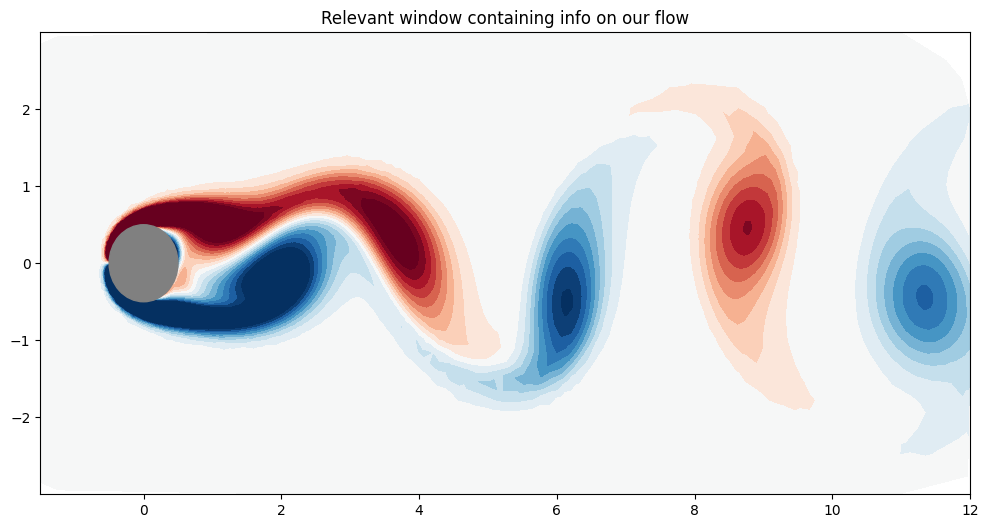

In [20]:
# plt.scatter(cropped_coords[0], cropped_coords[1], s=3, c = cropped_data[-1,2,:], cmap=RdBu)
fig, ax = plt.subplots(figsize=(12,6))
plot_cyl(cropped_coords,cropped_data[-1,2,:],ax)
ax.set_title('Relevant window containing info on our flow')
plt.show()

# Interpolation

In [21]:
from scipy.interpolate import griddata

In [90]:
# Make a mesh with a resolution slightly bigger than the smallest dx

delta = 0.1
Nx = int((x_max - x_min)/delta) +1 
Ny = int((y_max - y_min)/delta) +1 

xx = np.linspace(x_min, x_max, Nx)
yy = np.linspace(y_min, y_max, Ny)

X, Y = np.meshgrid(xx, yy)

In [60]:
interpolated_vorticity = np.zeros((cropped_data.shape[0], X.shape[0], X.shape[1]))
for i in range(cropped_data.shape[0]):
    interpolated_vorticity[i] = griddata(cropped_coords.T, cropped_data[i,2,:], (X, Y), method='cubic')

In [91]:
interpolated_vorticity_nearest = np.zeros((cropped_data.shape[0], X.shape[0], X.shape[1]))
for i in range(cropped_data.shape[0]-10,cropped_data.shape[0]):
    interpolated_vorticity_nearest[i] = griddata(cropped_coords.T, cropped_data[i,2,:], (X, Y), method='nearest')

In [50]:
interpolated_vorticity[-1,:,:].shape

(61, 141)

In [65]:
np.max(interpolated_vorticity_nearest[-1,:,:])
np.min(interpolated_vorticity_nearest[-1,:,:])

-23.04514737340498

In [62]:
interpolated_vorticity_nearest[-1,:,:]

array([[-0.0109879 , -0.0109879 , -0.0109879 , ..., -0.00861225,
        -0.00861225, -0.00861225],
       [-0.0109879 , -0.0109879 , -0.0109879 , ..., -0.00861225,
        -0.00861225, -0.00861225],
       [-0.0109879 , -0.0109879 , -0.0109879 , ..., -0.00861225,
        -0.00861225, -0.00861225],
       ...,
       [ 0.01058982,  0.01058982,  0.01058982, ...,  0.00735863,
         0.00735863,  0.00735863],
       [ 0.01058982,  0.01058982,  0.01058982, ...,  0.00735863,
         0.00735863,  0.00735863],
       [ 0.01058982,  0.01058982,  0.01058982, ...,  0.00735863,
         0.00735863,  0.00735863]])

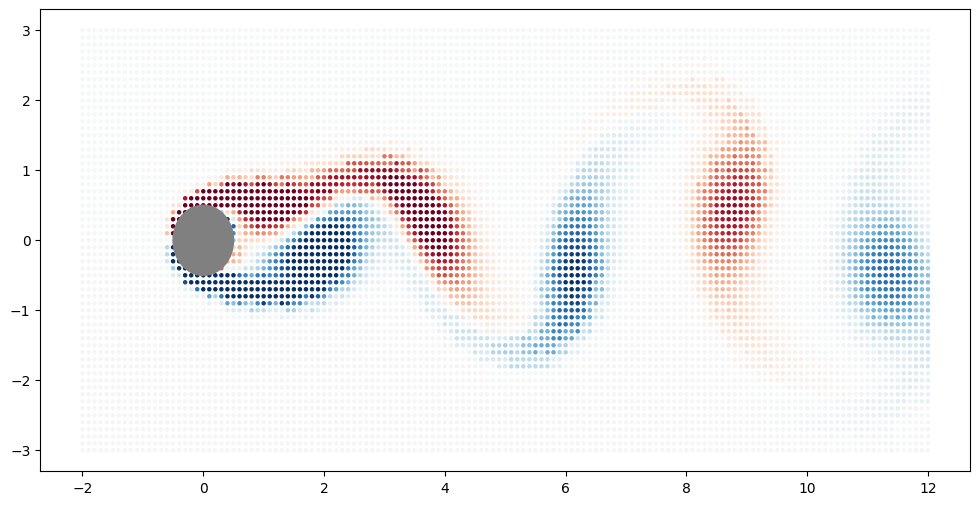

In [92]:
# numOfLevels=18
# vort_levels = np.append(np.append(np.array([-40]),np.linspace(-2,2,numOfLevels)),40)
fig, ax = plt.subplots(figsize=(12,6))

circle = plt.Circle((0, 0), 0.5, color='grey', clip_on=False)
ax.scatter(X,Y,5,interpolated_vorticity_nearest[-1,:,:], cmap='RdBu', vmin=-2, vmax = 2)
ax.add_patch(circle)

Contour plots are not being nice, idk why...

Probably need to manually set the values inside the circle to 0 so that the auto-encoder doesn't try fitting garbage data